In [1]:
import numpy as np

from scipy.optimize import curve_fit
from scipy.io import loadmat
from ImageProcessing import *

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

from ImageProcessing import *
from ImageGenerator import ImageGenerator
from ImageClassifier import *

from sklearn.mixture import GaussianMixture

2023-06-21 15:15:06.730631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading Data

In [2]:
data = loadmat('jun1_run9.mat')
n_loops = 20
lattice_shape = np.array([10, 10])
stack = data['stack']

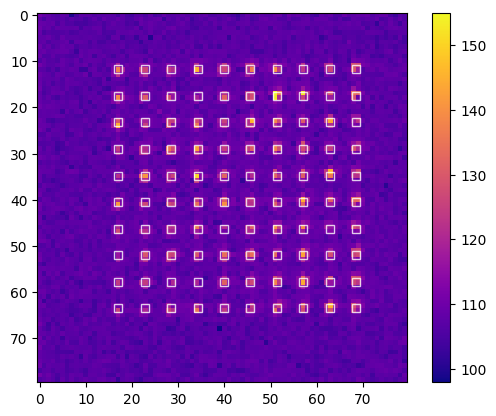

In [3]:
processor = GreenImageProcessor(stack, lattice_shape, 20)
processor.plot()

In [4]:
crops = processor.crop_sites(1)
crop = np.mean(crops[0], axis=(2,3)).flatten()
counts, bins = np.histogram(crop, bins=(processor.per_loop // 4))
centers = (bins[:-1] + bins[1:]) / 2

AxisError: axis 2 is out of bounds for array of dimension 2

# Playing with Scikit's mixed gaussian model fitting

In [ ]:
tot = np.sum(crop)
mix = GaussianMixture(2)
mix.fit(np.reshape(crop, (crop.shape[0], 1)))
means = mix.means_.flatten()
weights = mix.weights_.flatten()
std = np.sqrt(mix.covariances_.flatten())
print(tot)

NameError: name 'crop' is not defined

In [ ]:
counts, bins, _ = plt.hist(crop, bins=(processor.per_loop  // 4), density=True)
x = np.linspace(centers[0], centers[-1])
print(counts)
#print(weights)
#print(gaussian(x, means[0], std[0], weights[0]))
plt.plot(x, 0.398942280401 * (gaussian(x, means[0], std[0], weights[0]) / std[0] + gaussian(x, means[1], std[1], weights[1] / std[1])))

NameError: name 'plt' is not defined

# Fixing anomolous bright/dark thresholding

In [8]:
upper_thresh = 7
lower_thresh = 3
arr = np.array([8, 11, 11, 9, 8, 11, 9, 5, 2, 3, 2, 1, 3, 4, 5, 11, 10, 11, 10, 10])
over_thresh = np.arange(arr.size)[arr >= upper_thresh]
under_thresh = np.arange(arr.size)[arr <= lower_thresh]
labels = np.empty(arr.size)
print(over_thresh)
print(under_thresh)

[ 0  1  2  3  4  5  6 15 16 17 18 19]
[ 8  9 10 11 12]


In [9]:
def slicer(arr, upper_thresh, lower_thresh, labels):
    head = tail = 0
    bright = True
    for i, val in enumerate(arr):
        if val >= upper_thresh and bright:
            head = i + 1
        elif val >= upper_thresh and not bright:
            labels[head:i] = np.full(i - head - 1, np.NaN)
            labels[tail:head] = np.zeros(head - tail)
            tail = i
            head = i + 1
            bright = True
        elif val <= lower_thresh and not bright:
            head = i + 1
        elif val <= lower_thresh and bright:
            labels[head:i] = np.full(i - head, np.NaN)
            labels[tail:head] = np.ones(head - tail)
            tail = i
            head = i + 1
            bright = False
    if bright:
        labels[tail:head] = np.ones(head - tail)
        labels[head:] = np.full(labels.size - head, np.NaN)
    else:
        labels[head:] = np.zeros(labels.size - head)


In [10]:
slicer(arr, upper_thresh, lower_thresh, labels)
print(labels)

[ 1.  1.  1.  1.  1.  1.  1. nan  0.  0.  0.  0.  0. nan nan  1.  1.  1.
  1.  1.]
